In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import linear_model
from sklearnex import patch_sklearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

patch_sklearn()
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def smote(x, y, c):
    if c==1:
        oversample = SMOTE()
    elif c==2:
        oversample = BorderlineSMOTE()
    elif c==3:
        oversample = SVMSMOTE()
    elif c==0:
        oversample = ADASYN()

    return oversample.fit_resample(x, y)

## Read Data

In [3]:
# df = pd.read_excel("../data/newData/MergedImputed.xlsx")
df = pd.read_excel("./data/MergedImputed_TimeConstrained.xlsx")

print(len(df["Patient ID"].unique()))

544


## Drop features with more than 80% missing values

In [4]:
ignore = ['Patient ID', 'Sample Date Time','Date of Discharge']

df_dropped = df.dropna(thresh=int(len(df)*0.2),axis=1)

columns_for_dups = []
for i in list(df_dropped):
    if i in ignore:
        continue
    else:
        columns_for_dups.append(i)

print (len(df_dropped))
df_dropped = df_dropped.drop_duplicates(subset = columns_for_dups)

print (len(df_dropped))
print (set(list(df))-set(list(df_dropped)))
df_dropped
print(len(df_dropped["Patient ID"].unique()))

16179
15648
{'SPO2 Supplimental O2', 'Band Cell_CBC (Complete Blood Count) EDTA', 'Atypical Large Cell_CBC (Complete Blood Count) EDTA', 'N', 'Nucleated RBCs_CBC (Complete Blood Count) EDTA', 'S Gene', 'ORF Gene', 'Comment(HbA1C)_Glycosylated Haemoglobin (HbA1C) EDTA', 'Metamyelocyte Cell_CBC (Complete Blood Count) EDTA', 'Comment :_CBC (Complete Blood Count) EDTA', 'Myelocyte Cell_CBC (Complete Blood Count) EDTA', 'Corrected TLC_CBC (Complete Blood Count) EDTA', 'Blasts_CBC (Complete Blood Count) EDTA'}
544


## Features to be Considered

In [5]:
features = [
 'Basophils_CBC (Complete Blood Count) EDTA',
 'Eosinophils_CBC (Complete Blood Count) EDTA',
 'Haemoglobin_CBC (Complete Blood Count) EDTA',
 'Lymphocytes_CBC (Complete Blood Count) EDTA',
 'MCH_CBC (Complete Blood Count) EDTA',
 'MCHC_CBC (Complete Blood Count) EDTA',
 'MCV_CBC (Complete Blood Count) EDTA',
 'Monocytes_CBC (Complete Blood Count) EDTA',
 'Neutrophils_CBC (Complete Blood Count) EDTA',
 'Packed Cell  Volume_CBC (Complete Blood Count) EDTA',
 'Platelet Count_CBC (Complete Blood Count) EDTA',
 'RDW_CBC (Complete Blood Count) EDTA',
 'Total Leucocyte Count (TLC)_CBC (Complete Blood Count) EDTA',
 'Absolute Lymphocyte Count_CBC (Complete Blood Count) EDTA',
 'Absolute Neutrophil Count_CBC (Complete Blood Count) EDTA',
 'Absolute Monocyte Count_CBC (Complete Blood Count) EDTA',
 'RBC Count_CBC (Complete Blood Count) EDTA',
 'MPV_CBC (Complete Blood Count) EDTA',
 'Gender',
 'Age',
 'Height',
 'Weight',
 'BMI',
 'Temperature',
 'BP Systolic',
 'BP Diastolic',
 'Pulse Rate',
 'SPO2 Room Air',
 'Respiration Rate',
 'Pregnancy',
 'Hypertension',
 'Diabetes',
 'Cancer',
 'Hyperlipidemia/dislipidemia',
 'Thyroid',
 'Heart/Circulatory System',
 'Respiratory',
 'Brain/Nervous System',
 'Renal',
 'Liver',
 'Other',
 'E',
 'RdRp',
 'Absolute Eosinophil Count_CBC (Complete Blood Count) EDTA',
 'Procalcitonin Level_Procalcitonin*  Serum',
 'Absolute Basophil Count_CBC (Complete Blood Count) EDTA',
 'INR_Prothrombin Time (with INR) Citrate Plasma',
 'Prothrombin Time (PT)_Prothrombin Time (with INR) Citrate Plasma',
 'MNPT Value_Prothrombin Time (with INR) Citrate Plasma',
 'Glycosylated Haemoglobin(Hb A1c)_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Average Glucose Value For the Last 3 Months_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Average Glucose Value For the Last 3 Months IFCC_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Glycosylated Haemoglobin(Hb A1c) IFCC_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Trop I_Trop I Serum (High Sensitive)',
 'CK-MB (Mass)_CK- MB (Mass) Serum',
 '25 Hydroxy- Vitamin D  Serum_25 Hydroxy Vitamin D Level Serum',
 'CRP_CRP- C-Reactive Protein',
 'Ferritin_Ferritin Serum',
 'IL-6_Interleukin -6 (IL-6)',
 'D-Dimer  (Quantitative)_D-Dimer  (Quantitative) Citrate Plasma',
 'Magnesium_Magnesium Serum',
 'LDH_LDH (Lactate Dehydrogenase) Total   Serum',
 'Creatine Kinase (CPK)_Creatine Kinase (CPK) Serum',
]
print (len(features))

63


### Define Task

In [6]:
# task = 'Severity Class'
# task = 'Mortality'
task = 'Binary Severity Class'

### Get Patient IDs

In [7]:
X_patients = []
Y_patients = []
for patient in df_dropped["Patient ID"].unique():
    X_patients.append(patient)
    Y_patients.append(df_dropped[df_dropped["Patient ID"]==patient].iloc[0][task])
def get_positions(array,indices):
    output = []
    for i in indices:
        output.append(array[i])
    return output

### Split Patient IDs into train test based on a date cutoff

In [8]:
trainp = df_dropped[df_dropped["Date of Discharge"]<np.datetime64("2020-09-11")]["Patient ID"].unique()
testp = df_dropped[df_dropped["Date of Discharge"]>np.datetime64("2020-09-11")]["Patient ID"].unique()

train = df_dropped[df_dropped["Patient ID"].isin(trainp)]
test = df_dropped[df_dropped["Patient ID"].isin(testp)]

## Get Feature Importances

In [9]:
xg_class = xgb.XGBClassifier(objective ='binary:logistic', gamma = 0, learning_rate=0.2, max_delta_step=0, max_depth=4, min_child_weight=0, reg_lambda=7, subsample=1.0)
xg_class.fit(train[features].values, train[task].values)
feature_importances = xg_class.feature_importances_

### Sort Features by Importance

Eosinophils_CBC (Complete Blood Count) EDTA 0.013183848
BP Systolic 0.013187185
25 Hydroxy- Vitamin D  Serum_25 Hydroxy Vitamin D Level Serum 0.013984598
Respiration Rate 0.014299883
Heart/Circulatory System 0.015305595
RBC Count_CBC (Complete Blood Count) EDTA 0.015453298
Weight 0.015462941
RdRp 0.015972994
Temperature 0.016817015
Glycosylated Haemoglobin(Hb A1c)_Glycosylated Haemoglobin (HbA1C) EDTA 0.018825492
MCV_CBC (Complete Blood Count) EDTA 0.020201942
Respiratory 0.020942941
Procalcitonin Level_Procalcitonin*  Serum 0.024399502
Absolute Basophil Count_CBC (Complete Blood Count) EDTA 0.025891514
Packed Cell  Volume_CBC (Complete Blood Count) EDTA 0.027855901
Absolute Eosinophil Count_CBC (Complete Blood Count) EDTA 0.031788405
SPO2 Room Air 0.034387566
IL-6_Interleukin -6 (IL-6) 0.037122607
INR_Prothrombin Time (with INR) Citrate Plasma 0.040556997
Ferritin_Ferritin Serum 0.04214232
Diabetes 0.0425717
Neutrophils_CBC (Complete Blood Count) EDTA 0.046866987
Lymphocytes_CBC (Comp

Text(0.5, 1.0, 'Top 25 Parameters for Risk Stratification')

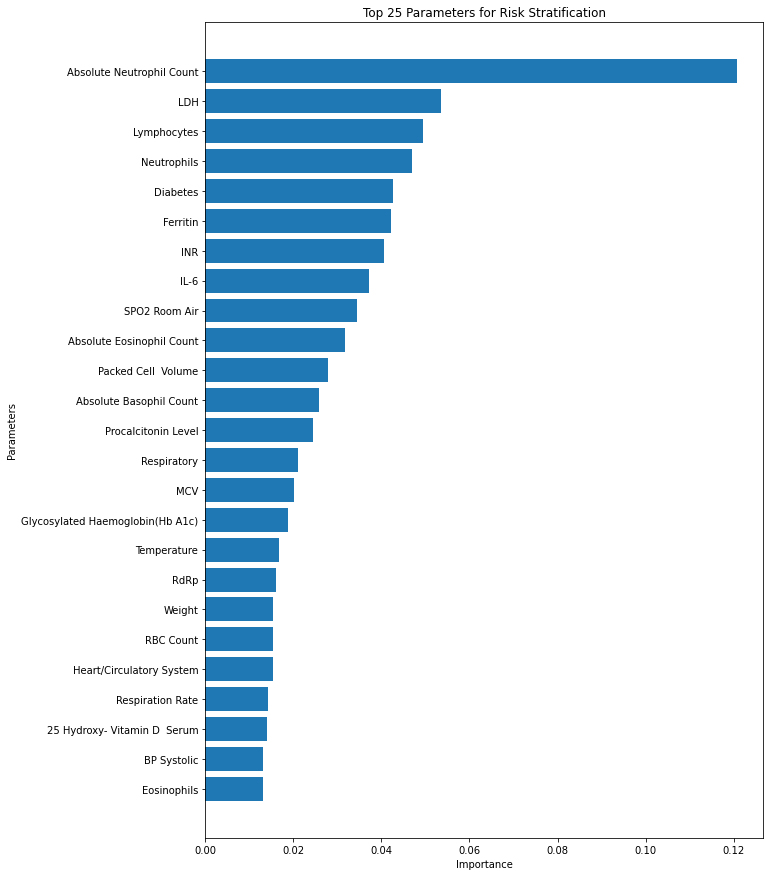

In [10]:
feature_names = []
importances = []

for i in (feature_importances).argsort()[-25:]:
    print (features[i],feature_importances[i])
    feature_names.append(features[i].split("_")[0])
    importances.append(feature_importances[i])

plt.rcParams['figure.figsize'] = [10, 15]
plt.barh(feature_names,importances)
plt.ylabel("Parameters")
plt.xlabel("Importance")
plt.title("Top 25 Parameters for Risk Stratification")
# plt.savefig(task+"Top25Features.jpg",bbox_inches="tight")

In [11]:
X_patients_train = []
Y_patients_train = []
for patient in train["Patient ID"].unique():
    X_patients_train.append(patient)
    Y_patients_train.append(df_dropped[df_dropped["Patient ID"]==patient].iloc[0][task])

### Perform 5 fold CV for feature selection

In [12]:
selected_features = []

for i in (-feature_importances).argsort()[:15]:
    selected_features.append(features[i])
    rskf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=0)
    gt = []
    predicted = []
    proba = []
    trainindices = []
    testindices = []
    predictors = []
    for train_index,test_index in tqdm(rskf.split(X_patients_train,Y_patients_train)):
        trainPatients = get_positions(X_patients_train,train_index)
        testPatients = get_positions(X_patients_train,test_index)

        traindf = train[train["Patient ID"].isin(trainPatients)]
        testdf = train[train["Patient ID"].isin(testPatients)]

        X_train, Y_train = traindf[selected_features].values, traindf[task].values
        X_test, Y_test = testdf[selected_features].values, testdf[task].values


        scaler = MinMaxScaler(feature_range=(0,1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        imputer = SimpleImputer(strategy="median")
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        X_train, Y_train = smote(X_train,Y_train,1)

        clf = xgb.XGBClassifier()
        clf.fit(X_train,Y_train)
        
        y_predicted = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        
        gt.append(Y_test)
        predicted.append(y_predicted)
        proba.append(y_proba)
        predictors.append([clf,scaler,imputer])

        trainindices.append(np.where(df_dropped["Patient ID"].isin(trainPatients)==True)[0])
        testindices.append(np.where(df_dropped["Patient ID"].isin(testPatients)==True)[0])

    predicted = np.concatenate(predicted,axis=0)
    gt = np.concatenate(gt,axis=0)
    proba = np.concatenate(proba,axis=0)
    # print ("")
    # print (task)

    del clf

    print (len(selected_features),roc_auc_score(gt,proba[:,1]))   

25it [00:40,  1.61s/it]


1 0.7095144678030896


25it [00:38,  1.53s/it]


2 0.7858426729967077


25it [00:41,  1.66s/it]


3 0.8029496191716085


25it [00:37,  1.51s/it]


4 0.8019334502179963


25it [00:40,  1.63s/it]


5 0.8149858530056723


25it [00:51,  2.06s/it]


6 0.8198501847770687


25it [01:07,  2.70s/it]


7 0.8219294534812209


25it [01:33,  3.75s/it]


8 0.8330020588543492


25it [05:01, 12.06s/it]


9 0.8677301326247286


25it [03:17,  7.91s/it]


10 0.8676986970692975


25it [01:29,  3.59s/it]


11 0.8686720992935351


25it [01:15,  3.01s/it]


12 0.8709028126383564


25it [03:41,  8.86s/it]


13 0.8699161885395424


25it [11:54, 28.57s/it]


14 0.8730082644945485


25it [11:51, 28.46s/it]

15 0.8674355351320568


In [13]:
def getMetrics(testX,testY,models,metric):
    clf = models[0]
    scaler = models[1]
    imputer = models[2]
    
    
    if metric != f1_score:
        ypredicted = clf.predict_proba(imputer.transform(scaler.transform(testX)))
        metric_value  = metric(testY,ypredicted[:,1])
    else:
        ypredicted = clf.predict(imputer.transform(scaler.transform(testX)))
        metric_value  = metric(testY,ypredicted)
    return metric_value

### Select number of Features that acheive max AUC Score

In [14]:
selected_features =  [features[i] for i in (-feature_importances).argsort()[:11]]
print(selected_features)

['Absolute Neutrophil Count_CBC (Complete Blood Count) EDTA', 'LDH_LDH (Lactate Dehydrogenase) Total   Serum', 'Lymphocytes_CBC (Complete Blood Count) EDTA', 'Neutrophils_CBC (Complete Blood Count) EDTA', 'Diabetes', 'Ferritin_Ferritin Serum', 'INR_Prothrombin Time (with INR) Citrate Plasma', 'IL-6_Interleukin -6 (IL-6)', 'SPO2 Room Air', 'Absolute Eosinophil Count_CBC (Complete Blood Count) EDTA', 'Packed Cell  Volume_CBC (Complete Blood Count) EDTA']


## Get Metrics on Test Set

In [15]:
X_train, Y_train = train[selected_features].values, train[task].values
X_test, Y_test = test[selected_features].values, test[task].values


scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

clf = xgb.XGBClassifier(colsample_bytree= 0.5586299571256016,
 learning_rate=0.015552512903662743,
 max_depth=5,
 min_child_weight= 1,
 n_estimators= 686,
 subsample= 0.8928391410802186)
# clf = RandomForestClassifier(max_depth=9,n_estimators=914)
# clf = xgb.XGBClassifier()
# clf = linear_model.LogisticRegression()
# clf = SVC(probability=True)
clf.fit(X_train,Y_train)
y_predicted = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)


print (classification_report(Y_test,y_predicted))
print (roc_auc_score(Y_test,y_proba[:,1])) 
print (average_precision_score(Y_test,y_proba[:,1])) 
confusion = confusion_matrix(Y_test,y_predicted)

              precision    recall  f1-score   support

           0       0.76      0.50      0.61      1135
           1       0.74      0.90      0.81      1776

    accuracy                           0.74      2911
   macro avg       0.75      0.70      0.71      2911
weighted avg       0.75      0.74      0.73      2911

0.8167254534269952
0.8770632536623928


In [16]:
X_test, Y_test = test[selected_features].values, test[task].values

print (classification_report(Y_test,clf.predict(imputer.transform(scaler.transform(X_test)))))

              precision    recall  f1-score   support

           0       0.76      0.50      0.61      1135
           1       0.74      0.90      0.81      1776

    accuracy                           0.74      2911
   macro avg       0.75      0.70      0.71      2911
weighted avg       0.75      0.74      0.73      2911



## Get Metrics over 5 different CV runs

In [17]:
import copy
from sklearn.base import clone
clfs = [xgb.XGBClassifier(colsample_bytree= 0.5586299571256016,
 learning_rate=0.015552512903662743,
 max_depth=5,
 min_child_weight= 1,
 n_estimators= 686,
 subsample= 0.8928391410802186),
       RandomForestClassifier(max_depth=9,n_estimators=914),
       SVC(probability=True),
       linear_model.LogisticRegression()]
all_predictors = []
for i in clfs:
    rskf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=0)
    gt = []
    predicted = []
    proba = []
    trainindices = []
    testindices = []
    predictors = []
    for train_index,test_index in tqdm(rskf.split(X_patients_train,Y_patients_train)):
        trainPatients = get_positions(X_patients_train,train_index)
        testPatients = get_positions(X_patients_train,test_index)

        traindf = train[train["Patient ID"].isin(trainPatients)]
        testdf = train[train["Patient ID"].isin(testPatients)]

        X_train, Y_train = traindf[selected_features].values, traindf[task].values
        X_test, Y_test = testdf[selected_features].values, testdf[task].values

        scaler = MinMaxScaler(feature_range=(0,1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        imputer = SimpleImputer()
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        X_train, Y_train = smote(X_train,Y_train,1)
        clf = clone(i)

        clf.fit(X_train,Y_train)
        y_predicted = clf.predict(X_test)
        gt.append(Y_test)
        predicted.append(y_predicted)
        predictors.append([clf,scaler,imputer])

    all_predictors.append(predictors)

    predicted = np.concatenate(predicted,axis=0)
    gt = np.concatenate(gt,axis=0)
    print ("",clf)
    print (task)
    print (classification_report(gt,predicted))

25it [16:46, 40.24s/it]


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5586299571256016, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.015552512903662743, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=686, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8928391410802186, tree_method='exact',
              validate_parameters=1, verbosity=None)
Binary Severity Class
              precision    recall  f1-score   support

           0       0.61      0.75      0.67     14965
           1       0.92      0.85      0.88     48720

    accuracy                           0.83     63685
   macro avg       0.76      0.80      0.78     63685
weighted avg       0.84      0.83      0.83     63685



25it [04:20, 10.41s/it]


 RandomForestClassifier(max_depth=9, n_estimators=914)
Binary Severity Class
              precision    recall  f1-score   support

           0       0.60      0.76      0.67     14965
           1       0.92      0.84      0.88     48720

    accuracy                           0.82     63685
   macro avg       0.76      0.80      0.77     63685
weighted avg       0.84      0.82      0.83     63685



25it [22:29, 53.97s/it]


 SVC(probability=True)
Binary Severity Class
              precision    recall  f1-score   support

           0       0.52      0.83      0.64     14965
           1       0.94      0.77      0.84     48720

    accuracy                           0.78     63685
   macro avg       0.73      0.80      0.74     63685
weighted avg       0.84      0.78      0.80     63685



25it [00:01, 13.61it/s]


 LogisticRegression()
Binary Severity Class
              precision    recall  f1-score   support

           0       0.53      0.83      0.65     14965
           1       0.94      0.78      0.85     48720

    accuracy                           0.79     63685
   macro avg       0.74      0.80      0.75     63685
weighted avg       0.84      0.79      0.80     63685



#### AUC_ROC Score 

In [18]:
means = []
stds = []
X_test, Y_test = test[selected_features].values, test[task].values
for predictors in all_predictors:
    performance = []
    for i in predictors:
        performance.append(getMetrics(testX=X_test,testY=Y_test,metric=roc_auc_score,models = i))
    print (i,"\n",np.mean(performance),"+-",np.std(performance))
    means.append(np.mean(performance))
    stds.append(np.std(performance))

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5586299571256016, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.015552512903662743, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=686, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8928391410802186, tree_method='exact',
              validate_parameters=1, verbosity=None), MinMaxScaler(), SimpleImputer()] 
 0.8331815890780647 +- 0.007947393920180167
[RandomForestClassifier(max_depth=9, n_estimators=914), MinMaxScaler(), SimpleImputer()] 
 0.8256464460054768 +- 0.00992799840321555
[SVC(probability=True), MinMaxScaler(), SimpleImputer()] 
 0.8161854288208913 +- 0.008003380734376462
[LogisticRegression(), MinMaxScaler(), SimpleI

#### Average Precision

In [19]:
means = []
stds = []
X_test, Y_test = test[selected_features].values, test[task].values
for predictors in all_predictors:
    performance = []
    for i in predictors:
        performance.append(getMetrics(testX=X_test,testY=Y_test,metric=average_precision_score,models = i))
    print (i,"\n",np.mean(performance),"+-",np.std(performance))
    means.append(np.mean(performance))
    stds.append(np.std(performance))



[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5586299571256016, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.015552512903662743, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=686, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8928391410802186, tree_method='exact',
              validate_parameters=1, verbosity=None), MinMaxScaler(), SimpleImputer()] 
 0.8913218302947306 +- 0.007424079832399521
[RandomForestClassifier(max_depth=9, n_estimators=914), MinMaxScaler(), SimpleImputer()] 
 0.8773605912733331 +- 0.01366767607330317
[SVC(probability=True), MinMaxScaler(), SimpleImputer()] 
 0.8835937793131567 +- 0.005774062564338676
[LogisticRegression(), MinMaxScaler(), SimpleI

#### F1 Score

In [20]:
means = []
stds = []
X_test, Y_test = test[selected_features].values, test[task].values
for predictors in all_predictors:
    performance = []
    for i in predictors:
        performance.append(getMetrics(testX=X_test,testY=Y_test,metric=f1_score,models = i))
    print (i,"\n",np.mean(performance),"+-",np.std(performance))
    means.append(np.mean(performance))
    stds.append(np.std(performance))



[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5586299571256016, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.015552512903662743, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=686, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8928391410802186, tree_method='exact',
              validate_parameters=1, verbosity=None), MinMaxScaler(), SimpleImputer()] 
 0.8106055860143405 +- 0.007708367022400825
[RandomForestClassifier(max_depth=9, n_estimators=914), MinMaxScaler(), SimpleImputer()] 
 0.8034631128266441 +- 0.010430327228802267
[SVC(probability=True), MinMaxScaler(), SimpleImputer()] 
 0.7521350205656351 +- 0.013861545717370187
[LogisticRegression(), MinMaxScaler(), Simple